# ALTEGRAD - Detection of questions with same meaning

This notebook loads the data, extract features, classify the test set and save it to 'submissions.csv', a file to be submitted on Kaggle.

## Definition of the problem

The problem is a set of pairs of questions, where the output to predict is whether both questions in a pair have the same meaning or not.

Let's first import some libraries and define functions for score computations, cross-validation, etc.

In [1]:
import numpy as np
import unidecode

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import GridSearchCV


from tools import *

## Load the data from CSV files

The data is first loaded from CSV files, with all texts saved in a dictionary with IDs as keys, and pairs storing pairs of text IDs.

In [2]:
texts = {}
pairs_train = []
pairs_test = []
y_train = []

train_path = 'train.csv'
test_path = 'test.csv'

texts = {}
nb_lines = 10000
pairs_train, y_train = read_csv(train_path, texts, nb_lines = nb_lines)
pairs_test = read_csv(test_path, texts, labelled = False, nb_lines = nb_lines)

    
preprocess_texts(texts, stem = False)

## Feature extraction

In [3]:
from collections import Counter
from itertools import chain

def get_vocab(lst):
    print(w for txt in lst for w in lst[txt].split())
    vocabcount = Counter(w for txt in lst for w in lst[txt].split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

vocab, vocabcount = get_vocab(texts)

<generator object get_vocab.<locals>.<genexpr> at 0x7f669cf0b3b8>


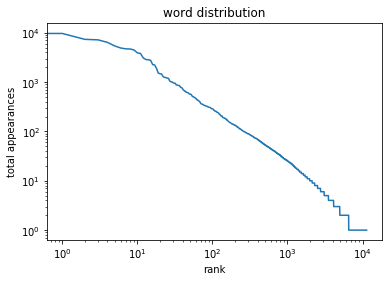

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [5]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

word2idx, idx2word = get_idx(vocab, vocabcount)

In [6]:
from keras.utils.data_utils import get_file

embedding_dim = 100

fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = os.path.expanduser(os.path.join('~', '.keras'))

if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
datadir = os.path.join(datadir_base, 'datasets')

glove_name = os.path.join(datadir, fname)


#if not os.path.exists(glove_name):
#    path = 'glove.6B.zip'
#    new_path = get_file(path, origin="http://nlp.stanford.edu/data/glove.6B.zip")
#    !unzip {datadir}/{path}

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
glove_n_symbols = !wc -l {fname}
glove_n_symbols = int(glove_n_symbols[0].split()[0])
print(glove_n_symbols)

import numpy as np
glove_index_dict = {}
glove_embedding_weights = np.empty((glove_n_symbols, embedding_dim))
globale_scale=.1
with open(fname, 'r') as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i
        glove_embedding_weights[i,:] = list(map(float,l[1:]))
        i += 1
glove_embedding_weights *= globale_scale

print(glove_embedding_weights.std())

for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

400000
0.04081572760019029


In [8]:
import re

def get_embed(w): 
    if w != "" and all(x.isalpha() or x.isspace() for x in w) and w in glove_index_dict:
        return glove_embedding_weights[glove_index_dict[w]]
    else:
        return [0.] * embedding_dim
text_embed = dict()
for it in texts.items():
    text_embed[it[0]] = np.array([0.] * embedding_dim)
    for w in it[1].split(" "):
        text_embed[it[0]] += np.array(get_embed(w))

In [9]:


seed = 42
vocab_size = len(idx2word)

# generate random embedding with same scale as glove
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04080459505140145
number of tokens, in small vocab, found in glove and copied to embedding 10286 0.9080155367231638


In [10]:
def tfidf(texts):
    ids2ind = {} # will contain the row idx of each unique text in the TFIDF matrix 
    for qid in texts:
        ids2ind[qid] = len(ids2ind)

    vec = TfidfVectorizer(ngram_range=(1, 3))
    A = vec.fit_transform(texts.values())

    return ids2ind, A


def compute_features(pairs):
    N = len(pairs)
    X = []
    for i in range(len(pairs)):
        q1 = pairs[i][0]
        q2 = pairs[i][1]
        
        X.append(np.concatenate((text_embed[q1], text_embed[q2])))
        #X[i,0] = cosine_similarity(A[ids2ind[q1],:], A[ids2ind[q2],:])
        #X[i,1] = len(texts[q1].split()) + len(texts[q2].split())
        #X[i,2] = abs(len(texts[q1].split()) - len(texts[q2].split()))

    return N, X


In [11]:
#ids2ind, A = tfidf(texts)

N_train, X_train = compute_features(pairs_train)
N_test, X_test = compute_features(pairs_test)

## Classification

In [16]:
clf = MLPClassifier(())
#clf = LogisticRegression() #svm.SVC()
#RandomForestClassifier(n_estimators=50, max_depth = 4, n_jobs=-1)

print("clf")
clf.fit(X_train, y_train)

print("cv")
print_score(clf, X_train, y_train, cv = 4)

clf
cv
CV Fold 0
		acc	loss
train		1.00	0.04
test		0.72	1.20

CV Fold 1
		acc	loss
train		0.98	0.09
test		0.74	0.89

CV Fold 2
		acc	loss
train		0.96	0.10
test		0.75	1.05

CV Fold 3
		acc	loss
train		0.88	0.30
test		0.73	0.57

Bagged scores
train		0.95	0.30
test		0.74	0.93


In [ ]:
y_pred = clf.predict_proba(X_test)

sub_path = 'submissions.csv'
save_submission(sub_path, y_pred)

References

In [66]:
from tensorflow.contrib import keras
from keras.layers import Input, Embedding, Flatten, Dense, Dropout
from keras.layers import Dot
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()
model.add(Dense(32, input_shape=(200,)))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer=Adam(lr=0.001),
              loss='mae',
              metrics=['mse'])


In [67]:
print(np.array(X_train).shape)
print(np.array(X_train), y_train)
model.fit(np.array(X_train), y_train, epochs=10, batch_size = 10)



(10000, 200)
[[-0.1223678   0.1208845   0.414478   ... -0.7945588   0.8417273
   0.6203623 ]
 [-0.126672    0.182706    0.44663545 ... -0.602352    0.4955086
   0.37951386]
 [-0.1081606   0.43485398  0.44779299 ...  0.101162    0.569521
   0.110182  ]
 ...
 [-0.0576577   0.4987876   0.4841386  ... -0.4640505   0.491094
   0.3259    ]
 [-0.1814263   0.3847766   0.308206   ... -0.3821387   0.393667
   0.1970416 ]
 [-0.1848081   0.0656204   0.4634144  ... -0.3707473   0.6872343
   0.5212144 ]] [0 0 1 ... 1 0 1]
Epoch 1/10
10000/10000 [==============================] - 2s 188us/step - loss: 0.3459 - mean_squared_error: 0.3459
Epoch 2/10
10000/10000 [==============================] - 2s 151us/step - loss: 0.3459 - mean_squared_error: 0.3459
Epoch 3/10
10000/10000 [==============================] - 2s 151us/step - loss: 0.3459 - mean_squared_error: 0.3459
Epoch 4/10
10000/10000 [==============================] - 2s 154us/step - loss: 0.3459 - mean_squared_error: 0.3459
Epoch 5/10
10000/10000

In [40]:
model.predict(X_test)

KeyboardInterrupt: 